In [1]:
import numpy as np
import string
import pandas as pd
import nltk
import keras
import os

from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

from nltk.corpus import stopwords

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os


# modify the data folder accordingly
data_folder = "data/"
cache_folder = "cache/"

stop_words = set(stopwords.words("english") + list(string.punctuation))

Using TensorFlow backend.


# LSTM Model

In [409]:
data = pd.read_csv("data/Raw_data_new_sentiment.csv")

In [410]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [411]:
data

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD,percentage,change,Sentiment_1,Sentiment_total,Sentiment_component
0,2017/11/12 05:00,ETHUSD,312.34,316.34,308.00,310.16,3263.16,1017470.49,0.000000,0,0.0,0.000000,0.0000
1,2017/11/12 06:00,ETHUSD,310.16,310.16,301.12,307.00,3463.15,1056163.67,-0.010188,-1,0.0,0.000000,0.0000
2,2017/11/12 07:00,ETHUSD,307.00,314.37,301.37,307.16,6681.07,2066540.88,0.000521,1,0.0,0.000000,0.0000
3,2017/11/12 08:00,ETHUSD,307.16,310.00,302.48,304.79,2152.84,656841.26,-0.007716,-1,-1.0,-0.142454,0.0000
4,2017/11/12 09:00,ETHUSD,304.79,305.00,300.38,302.40,2832.44,857577.88,-0.007841,-1,0.0,0.000000,-0.1531
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20906,2020/4/1 07:00,ETHUSD,132.46,134.49,132.08,132.55,2955.84,393453.46,0.000679,1,0.0,0.000000,0.0000
20907,2020/4/1 08:00,ETHUSD,132.55,132.58,131.68,132.28,802.42,106059.43,-0.002037,-1,0.0,0.000000,0.0000
20908,2020/4/1 09:00,ETHUSD,132.28,132.32,131.54,132.20,203.96,26906.66,-0.000605,-1,0.0,0.000000,0.0000
20909,2020/4/1 10:00,ETHUSD,132.20,132.29,131.94,132.17,2509.86,331220.30,-0.000227,-1,0.0,0.000000,0.0000


In [412]:
import numpy as np

In [413]:
TRAIN_SPLIT = 16000

In [414]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [415]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [416]:
def create_time_steps(length):
  return list(range(-length, 0))

In [417]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

##  Baseline Model (Price Data Only)

In [298]:
feature_list =  ["Close", "Volume ETH", "Volume USD"]
features_0 = data[feature_list]
features_0.index = data["Date"]

In [299]:
## Standardize data
#dataset_0 = features_0.values
#data_mean_0 = dataset_0[:TRAIN_SPLIT].mean(axis=0)
#data_std_0 = dataset_0[:TRAIN_SPLIT].std(axis=0)
#dataset_0 = (dataset_0-data_mean_0)/data_std_0

In [300]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset_0 = sc.fit_transform(features_0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x16e2027b8>],
      dtype=object)

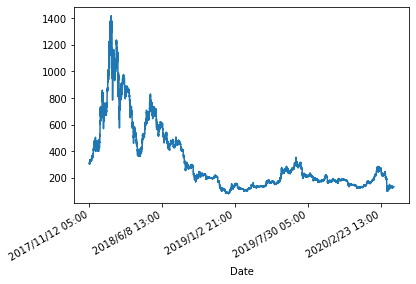

In [301]:
features_0["Close"].plot(subplots=True)

### Single Step Model

In [362]:
past_history = 24
future_target = 1
STEP = 1

BATCH_SIZE = 48
BUFFER_SIZE = 10000

x_train_single_0, y_train_single_0 = multivariate_data(dataset_0, dataset_0[:, -3], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single_0, y_val_single_0 = multivariate_data(dataset_0, dataset_0[:, -3],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single_0 = tf.data.Dataset.from_tensor_slices((x_train_single_0, y_train_single_0))
train_data_single_0 = train_data_single_0.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single_0 = tf.data.Dataset.from_tensor_slices((x_val_single_0, y_val_single_0))
val_data_single_0 = val_data_single_0.batch(BATCH_SIZE).repeat()

single_step_model_0 = tf.keras.models.Sequential()
single_step_model_0.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single_0.shape[-2:]))
single_step_model_0.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
single_step_model_0.add(tf.keras.layers.Dense(1))

single_step_model_0.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Baseline Model
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 4s 43ms/step - loss: 0.0420 - val_loss: 0.0034
Epoch 2/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0192 - val_loss: 0.0091
Epoch 3/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0158 - val_loss: 0.0020
Epoch 4/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0175 - val_loss: 0.0089
Epoch 5/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0184 - val_loss: 0.0027
Epoch 6/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0139 - val_loss: 0.0057
Epoch 7/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0128 - val_loss: 0.0051
Epoch 8/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0164 - val_loss: 0.0047


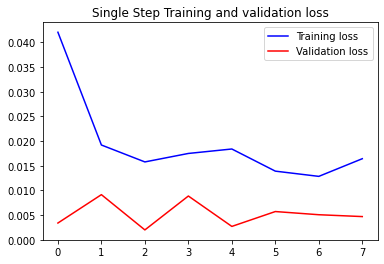

In [363]:
EVALUATION_INTERVAL = 100
EPOCHS = 20
    
print("=============================================================")
print("Baseline Model")
print("=============================================================")

from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

single_step_history_0 = single_step_model_0.fit(train_data_single_0, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single_0,
                                            validation_steps=50,
                                            callbacks=[earlyStop])
    
plot_train_history(single_step_history_0,
                   'Single Step Training and validation loss')

In [364]:
single_step_model_0.evaluate(x_train_single_0,y_train_single_0, verbose=0)

0.006193445050346192

In [365]:
single_step_model_0.evaluate(x_val_single_0,y_val_single_0, verbose=0)

0.0021270691499124363

In [366]:
predict_0 = single_step_model_0.predict(x_val_single_0)
true_0 = y_val_single_0

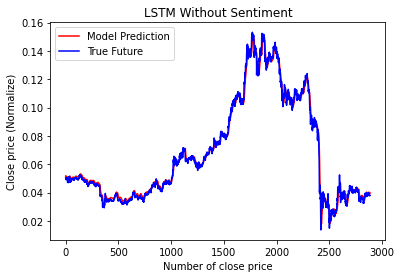

In [367]:
x = list(range(1, len(predict_0)+1))

plt.plot(x, predict_0, color="red", label="Model Prediction")
plt.plot(x, true_0, color="blue", label="True Future")

plt.title('LSTM Without Sentiment')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalize)')
plt.legend()
plt.show()

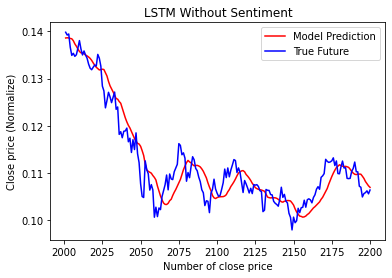

In [368]:
x = list(range(1, len(predict_0)+1))

plt.plot(x[2000:2200], predict_0[2000:2200], color="red", label="Model Prediction")
plt.plot(x[2000:2200], true_0[2000:2200], color="blue", label="True Future")

plt.title('LSTM Without Sentiment')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalize)')
plt.legend()
plt.show()

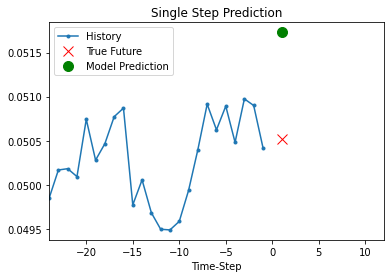

In [369]:
for x, y in val_data_single_0.take(1):
  plot = show_plot([x[0][:,-3].numpy(), y[0].numpy(),
                    single_step_model_0.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

- AUC Score (Up or Down)

In [370]:
true_list = []
pred_list = []

for i in range(0,len(true_0)-1):
    if (true_0[i+1] - true_0[i] > 0):
        true_list.append(1)
    if (true_0[i+1] - true_0[i] < 0):
        true_list.append(-1)
    if (true_0[i+1] - true_0[i] == 0):
        true_list.append(0)
        
for i in range(0,len(predict_0)-1):
    if (predict_0[:,0][i+1] - true_0[i] > 0):
        pred_list.append(1)
    if (predict_0[:,0][i+1] - true_0[i] < 0):
        pred_list.append(-1)
    if (predict_0[:,0][i+1] - true_0[i] == 0):
        pred_list.append(0)
        
auc_score = sum(1 for x,y in zip(true_list,pred_list) if x == y) / len(true_list)
print(auc_score)

0.5074523396880416


In [371]:
up_true_list = []
down_true_list = []
up_pred_list = []
down_pred_list = []

for i in range(0,len(true_list)):
    if true_list[i] == 1:
        up_true_list.append(1)
        up_pred_list.append(pred_list[i])
    if true_list[i] == -1:
        down_true_list.append(-1)
        down_pred_list.append(pred_list[i])

In [372]:
auc_score_up = sum(1 for x,y in zip(up_true_list,up_pred_list) if x == y) / len(up_true_list)
print(auc_score_up)
auc_score_down = sum(1 for x,y in zip(down_true_list,down_pred_list) if x == y) / len(down_true_list)
print(auc_score_down)

0.6462491397109429
0.3702397743300423


### Multiple Step Model

In [373]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [374]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [375]:
future_target = 12

x_train_multi_0, y_train_multi_0 = multivariate_data(dataset_0, dataset_0[:, -3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi_0, y_val_multi_0 = multivariate_data(dataset_0, dataset_0[:, -3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi_0 = tf.data.Dataset.from_tensor_slices((x_train_multi_0, y_train_multi_0))
train_data_multi_0 = train_data_multi_0.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_0 = tf.data.Dataset.from_tensor_slices((x_val_multi_0, y_val_multi_0))
val_data_multi_0 = val_data_multi_0.batch(BATCH_SIZE).repeat()

multi_step_model_0 = tf.keras.models.Sequential()
multi_step_model_0.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi_0.shape[-2:]))
multi_step_model_0.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model_0.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
multi_step_model_0.add(tf.keras.layers.Dense(12))

multi_step_model_0.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 7s 71ms/step - loss: 0.1735 - val_loss: 0.0176
Epoch 2/20
100/100 [==============================] - 4s 37ms/step - loss: 0.0709 - val_loss: 0.0115
Epoch 3/20
100/100 [==============================] - 4s 36ms/step - loss: 0.0472 - val_loss: 0.0136
Epoch 4/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0447 - val_loss: 0.0079
Epoch 5/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0456 - val_loss: 0.0080
Epoch 6/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0313 - val_loss: 0.0115
Epoch 7/20
100/100 [==============================] - 3s 34ms/step - loss: 0.0309 - val_loss: 0.0054
Epoch 8/20
100/100 [==============================] - 4s 37ms/step - loss: 0.0386 - val_loss: 0.0065
Epoch 9/20
100/100 [==============================] - 4s 35ms/step - loss: 0.0380 - val_loss: 0.0049
Epoch 10/20
100/100 [===========================

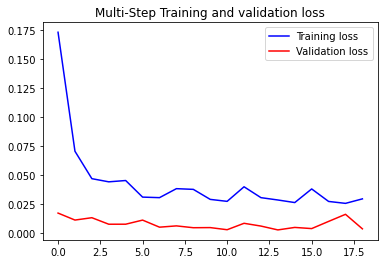

In [376]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

multi_step_history_0 = multi_step_model_0.fit(train_data_multi_0, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi_0,
                                          validation_steps=50,
                                          callbacks=[earlyStop])
plot_train_history(multi_step_history_0, 'Multi-Step Training and validation loss')

In [377]:
multi_step_model_0.evaluate(x_train_multi_0,y_train_multi_0, verbose=0)

0.013152556935344745

In [378]:
multi_step_model_0.evaluate(x_val_multi_0,y_val_multi_0, verbose=0)

0.003279140813458387

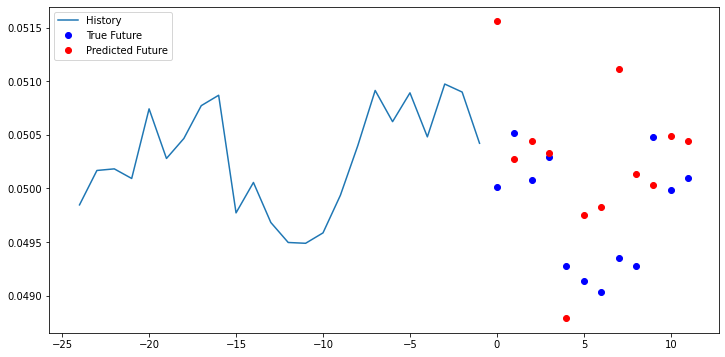

In [379]:
for x, y in val_data_multi_0.take(1):
    multi_step_plot(x[0], y[0], multi_step_model_0.predict(x)[0])

## Sentiment Model (Component Score)

In [380]:
feature_list =  ["Close", "Volume ETH", "Volume USD", "Sentiment_component"]
features_1 = data[feature_list]
features_1.index = data["Date"]

In [381]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset_1 = sc.fit_transform(features_1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1993adb00>],
      dtype=object)

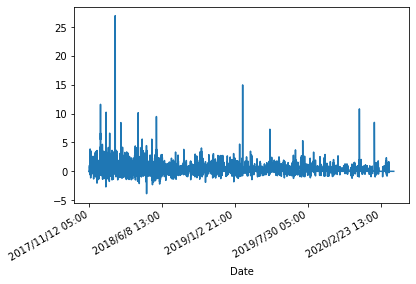

In [382]:
features_1["Sentiment_component"].plot(subplots=True)

### Single Step Model

In [383]:
past_history = 24
future_target = 1
STEP = 1

BATCH_SIZE = 48
BUFFER_SIZE = 10000

x_train_single_1, y_train_single_1 = multivariate_data(dataset_1, dataset_1[:, -4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single_1, y_val_single_1 = multivariate_data(dataset_1, dataset_1[:, -4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single_1 = tf.data.Dataset.from_tensor_slices((x_train_single_1, y_train_single_1))
train_data_single_1 = train_data_single_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single_1 = tf.data.Dataset.from_tensor_slices((x_val_single_1, y_val_single_1))
val_data_single_1 = val_data_single_1.batch(BATCH_SIZE).repeat()

single_step_model_1 = tf.keras.models.Sequential()
single_step_model_1.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single_1.shape[-2:]))
single_step_model_1.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
single_step_model_1.add(tf.keras.layers.Dense(1))

single_step_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Sentiment Model - Component
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 5s 45ms/step - loss: 0.0390 - val_loss: 0.0029
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0189 - val_loss: 0.0093
Epoch 3/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0160 - val_loss: 0.0033
Epoch 4/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0178 - val_loss: 0.0065
Epoch 5/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0184 - val_loss: 0.0025
Epoch 6/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0143 - val_loss: 0.0084
Epoch 7/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0134 - val_loss: 0.0046
Epoch 8/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0168 - val_loss: 0.0025
Epoch 9/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0150 - val_loss: 0.0048
Epoch 10/20
100/100 

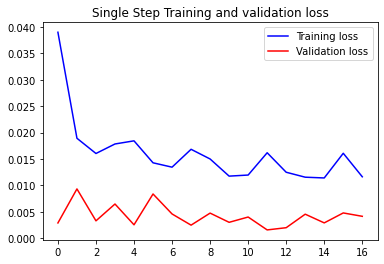

In [384]:
EVALUATION_INTERVAL = 100
EPOCHS = 20
    
print("=============================================================")
print("Sentiment Model - Component")
print("=============================================================")

from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

single_step_history_1 = single_step_model_1.fit(train_data_single_1, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single_1,
                                            validation_steps=50,
                                            callbacks=[earlyStop])
    
plot_train_history(single_step_history_1,
                   'Single Step Training and validation loss')

In [385]:
single_step_model_1.evaluate(x_train_single_1,y_train_single_1, verbose=0)

0.0040201400675030415

In [386]:
single_step_model_1.evaluate(x_val_single_1,y_val_single_1, verbose=0)

0.0017015714099845635

In [387]:
predict_1 = single_step_model_1.predict(x_val_single_1)
true_1 = y_val_single_1

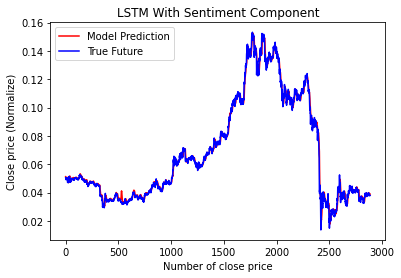

In [388]:
x = list(range(1, len(predict_1)+1))

plt.plot(x, predict_1, color="red", label="Model Prediction")
plt.plot(x, true_1, color="blue", label="True Future")

plt.title('LSTM With Sentiment Component')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalize)')
plt.legend()
plt.show()

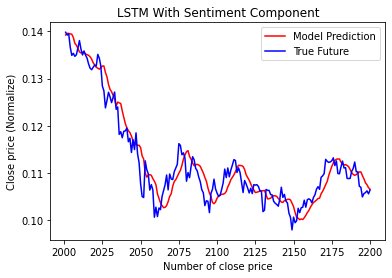

In [389]:
x = list(range(1, len(predict_1)+1))

plt.plot(x[2000:2200], predict_1[2000:2200], color="red", label="Model Prediction")
plt.plot(x[2000:2200], true_1[2000:2200], color="blue", label="True Future")

plt.title('LSTM With Sentiment Component')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalize)')
plt.legend()
plt.show()

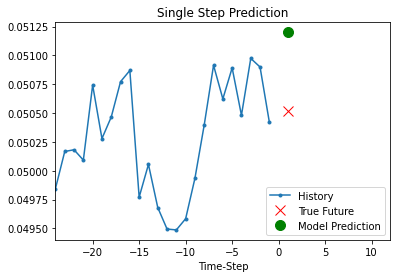

In [390]:
for x, y in val_data_single_1.take(1):
  plot = show_plot([x[0][:,-4].numpy(), y[0].numpy(),
                    single_step_model_1.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

-  AUC Score (Up or Down)

In [391]:
true_list = []
pred_list = []

for i in range(0,len(true_1)-1):
    if (true_1[i+1] - true_1[i] > 0):
        true_list.append(1)
    if (true_1[i+1] - true_1[i] < 0):
        true_list.append(-1)
    if (true_1[i+1] - true_1[i] == 0):
        true_list.append(0)
        
for i in range(0,len(predict_1)-1):
    if (predict_1[:,0][i+1] - true_1[i] > 0):
        pred_list.append(1)
    if (predict_1[:,0][i+1] - true_1[i] < 0):
        pred_list.append(-1)
    if (predict_1[:,0][i+1] - true_1[i] == 0):
        pred_list.append(0)
        
auc_score = sum(1 for x,y in zip(true_list,pred_list) if x == y) / len(true_list)
print(auc_score)

0.5230502599653379


In [392]:
up_true_list = []
down_true_list = []
up_pred_list = []
down_pred_list = []

for i in range(0,len(true_list)):
    if true_list[i] == 1:
        up_true_list.append(1)
        up_pred_list.append(pred_list[i])
    if true_list[i] == -1:
        down_true_list.append(-1)
        down_pred_list.append(pred_list[i])

In [393]:
auc_score_up = sum(1 for x,y in zip(up_true_list,up_pred_list) if x == y) / len(up_true_list)
print(auc_score_up)
auc_score_down = sum(1 for x,y in zip(down_true_list,down_pred_list) if x == y) / len(down_true_list)
print(auc_score_down)

0.6414315209910529
0.40691114245416077


### Multiple Steps Model

In [398]:
future_target = 12

x_train_multi_1, y_train_multi_1 = multivariate_data(dataset_1, dataset_1[:, -4], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi_1, y_val_multi_1 = multivariate_data(dataset_1, dataset_1[:, -4],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi_1 = tf.data.Dataset.from_tensor_slices((x_train_multi_1, y_train_multi_1))
train_data_multi_1 = train_data_multi_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_1 = tf.data.Dataset.from_tensor_slices((x_val_multi_1, y_val_multi_1))
val_data_multi_1 = val_data_multi_1.batch(BATCH_SIZE).repeat()

multi_step_model_1 = tf.keras.models.Sequential()
multi_step_model_1.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi_1.shape[-2:]))
multi_step_model_1.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model_1.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
multi_step_model_1.add(tf.keras.layers.Dense(12))

multi_step_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 8s 77ms/step - loss: 0.1149 - val_loss: 0.0208
Epoch 2/20
100/100 [==============================] - 4s 36ms/step - loss: 0.0449 - val_loss: 0.0116
Epoch 3/20
100/100 [==============================] - 4s 36ms/step - loss: 0.0341 - val_loss: 0.0104
Epoch 4/20
100/100 [==============================] - 4s 36ms/step - loss: 0.0364 - val_loss: 0.0054
Epoch 5/20
100/100 [==============================] - 4s 37ms/step - loss: 0.0398 - val_loss: 0.0124
Epoch 6/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0281 - val_loss: 0.0050
Epoch 7/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0262 - val_loss: 0.0056
Epoch 8/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0316 - val_loss: 0.0047
Epoch 9/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0299 - val_loss: 0.0090
Epoch 10/20
100/100 [===========================

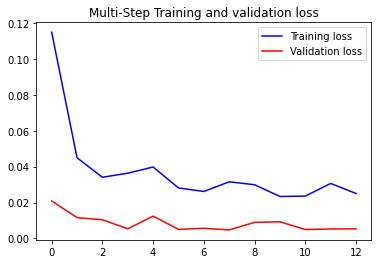

In [399]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

multi_step_history_1 = multi_step_model_1.fit(train_data_multi_1, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi_1,
                                          validation_steps=50,
                                          callbacks=[earlyStop])
plot_train_history(multi_step_history_1, 'Multi-Step Training and validation loss')

In [396]:
multi_step_model_1.evaluate(x_train_multi_1,y_train_multi_1, verbose=0)

0.012699300098006207

In [397]:
multi_step_model_1.evaluate(x_val_multi_1,y_val_multi_1, verbose=0)

0.006775625966651285

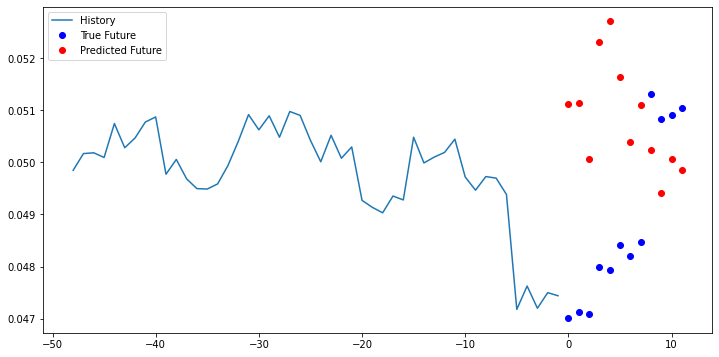

In [338]:
for x, y in val_data_multi_1.take(1):
    multi_step_plot(x[0], y[0], multi_step_model_1.predict(x)[0])

## Sentiment Model (total)

In [418]:
feature_list =  ["Close", "Volume ETH", "Volume USD", "Sentiment_component","Sentiment_total"]
features_2 = data[feature_list]
features_2.index = data["Date"]

In [419]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset_2 = sc.fit_transform(features_2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x17164a358>],
      dtype=object)

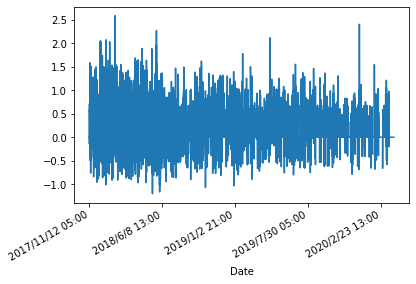

In [420]:
features_2["Sentiment_total"].plot(subplots=True)

### Single Step Model

In [421]:
past_history = 48
future_target = 1
STEP = 1

BATCH_SIZE = 48
BUFFER_SIZE = 10000

x_train_single_2, y_train_single_2 = multivariate_data(dataset_2, dataset_2[:, -5], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single_2, y_val_single_2 = multivariate_data(dataset_2, dataset_2[:, -5],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single_2 = tf.data.Dataset.from_tensor_slices((x_train_single_2, y_train_single_2))
train_data_single_2 = train_data_single_2.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single_2 = tf.data.Dataset.from_tensor_slices((x_val_single_2, y_val_single_2))
val_data_single_2 = val_data_single_2.batch(BATCH_SIZE).repeat()

single_step_model_2 = tf.keras.models.Sequential()
single_step_model_2.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single_2.shape[-2:]))
single_step_model_2.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
single_step_model_2.add(tf.keras.layers.Dense(1))

single_step_model_2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Sentiment Model 1
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 6s 63ms/step - loss: 0.0478 - val_loss: 0.0208
Epoch 2/20
100/100 [==============================] - 4s 35ms/step - loss: 0.0247 - val_loss: 0.0067
Epoch 3/20
100/100 [==============================] - 4s 39ms/step - loss: 0.0213 - val_loss: 0.0026
Epoch 4/20
100/100 [==============================] - 4s 39ms/step - loss: 0.0224 - val_loss: 0.0096
Epoch 5/20
100/100 [==============================] - 3s 35ms/step - loss: 0.0190 - val_loss: 0.0025
Epoch 6/20
100/100 [==============================] - 4s 37ms/step - loss: 0.0173 - val_loss: 0.0055
Epoch 7/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0188 - val_loss: 0.0076
Epoch 8/20
100/100 [==============================] - 3s 33ms/step - loss: 0.0179 - val_loss: 0.0017
Epoch 9/20
100/100 [==============================] - 3s 33ms/step - loss: 0.0152 - val_loss: 0.0080
Epoch 10/20
100/100 [=========

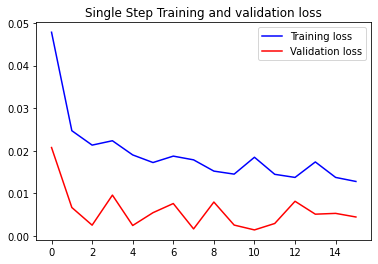

In [422]:
EVALUATION_INTERVAL = 100
EPOCHS = 20
    
print("=============================================================")
print("Sentiment Model 1")
print("=============================================================")

from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

single_step_history_2 = single_step_model_2.fit(train_data_single_2, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single_2,
                                            validation_steps=50,
                                            callbacks=[earlyStop])
    
plot_train_history(single_step_history_2,
                   'Single Step Training and validation loss')

In [423]:
single_step_model_2.evaluate(x_train_single_2,y_train_single_2, verbose=0)

0.008419424891163601

In [424]:
single_step_model_2.evaluate(x_val_single_2,y_val_single_2, verbose=0)

0.0019231049006047047

In [425]:
predict_2 = single_step_model_2.predict(x_val_single_2)
true_2 = y_val_single_2

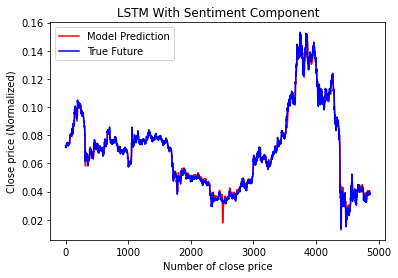

In [440]:
x = list(range(1, len(predict_2)+1))

plt.plot(x, predict_2, color="red", label="Model Prediction")
plt.plot(x, true_2, color="blue", label="True Future")

plt.title('LSTM With Sentiment Component')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalized)')
plt.legend()
plt.show()

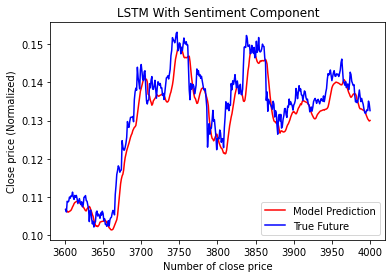

In [441]:
x = list(range(1, len(predict_2)+1))

plt.plot(x[3600:4000], predict_2[3600:4000], color="red", label="Model Prediction")
plt.plot(x[3600:4000], true_2[3600:4000], color="blue", label="True Future")

plt.title('LSTM With Sentiment Component')
plt.xlabel('Number of close price')
plt.ylabel('Close price (Normalized)')
plt.legend()
plt.show()

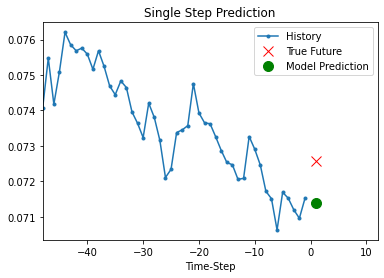

In [430]:
for x, y in val_data_single_2.take(1):
  plot = show_plot([x[0][:,-5].numpy(), y[0].numpy(),
                    single_step_model_2.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

- AUC Score

In [431]:
true_list = []
pred_list = []

for i in range(0,len(true_2)-1):
    if (true_2[i+1] - true_2[i] > 0):
        true_list.append(1)
    if (true_2[i+1] - true_2[i] < 0):
        true_list.append(-1)
    if (true_2[i+1] - true_2[i] == 0):
        true_list.append(0)
        
for i in range(0,len(predict_2)-1):
    if (predict_2[:,0][i+1] - true_2[i] > 0):
        pred_list.append(1)
    if (predict_2[:,0][i+1] - true_2[i] < 0):
        pred_list.append(-1)
    if (predict_2[:,0][i+1] - true_2[i] == 0):
        pred_list.append(0)
        
auc_score = sum(1 for x,y in zip(true_list,pred_list) if x == y) / len(true_list)
print(auc_score)

0.5114174038263731


In [432]:
up_true_list = []
down_true_list = []
up_pred_list = []
down_pred_list = []

for i in range(0,len(true_list)):
    if true_list[i] == 1:
        up_true_list.append(1)
        up_pred_list.append(pred_list[i])
    if true_list[i] == -1:
        down_true_list.append(-1)
        down_pred_list.append(pred_list[i])

In [433]:
auc_score_up = sum(1 for x,y in zip(up_true_list,up_pred_list) if x == y) / len(up_true_list)
print(auc_score_up)
auc_score_down = sum(1 for x,y in zip(down_true_list,down_pred_list) if x == y) / len(down_true_list)
print(auc_score_down)

0.5783582089552238
0.4491560312885961


### Multiple Steps Model

In [435]:
future_target = 12

x_train_multi_2, y_train_multi_2 = multivariate_data(dataset_2, dataset_2[:, -5], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi_2, y_val_multi_2 = multivariate_data(dataset_2, dataset_2[:, -5],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi_2 = tf.data.Dataset.from_tensor_slices((x_train_multi_2, y_train_multi_2))
train_data_multi_2 = train_data_multi_2.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_2 = tf.data.Dataset.from_tensor_slices((x_val_multi_2, y_val_multi_2))
val_data_multi_2 = val_data_multi_2.batch(BATCH_SIZE).repeat()

multi_step_model_2 = tf.keras.models.Sequential()
multi_step_model_2.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi_2.shape[-2:]))
multi_step_model_2.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model_2.add(tf.keras.layers.Dropout(0.2)) ## Add dropout
multi_step_model_2.add(tf.keras.layers.Dense(12))

multi_step_model_2.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 12s 118ms/step - loss: 0.1547 - val_loss: 0.0167
Epoch 2/20
100/100 [==============================] - 7s 66ms/step - loss: 0.0673 - val_loss: 0.0157
Epoch 3/20
100/100 [==============================] - 7s 72ms/step - loss: 0.0465 - val_loss: 0.0075
Epoch 4/20
100/100 [==============================] - 7s 71ms/step - loss: 0.0488 - val_loss: 0.0167
Epoch 5/20
100/100 [==============================] - 7s 67ms/step - loss: 0.0370 - val_loss: 0.0187
Epoch 6/20
100/100 [==============================] - 6s 64ms/step - loss: 0.0333 - val_loss: 0.0099
Epoch 7/20
100/100 [==============================] - 7s 69ms/step - loss: 0.0357 - val_loss: 0.0122
Epoch 8/20
100/100 [==============================] - 7s 72ms/step - loss: 0.0357 - val_loss: 0.0059
Epoch 9/20
100/100 [==============================] - 7s 74ms/step - loss: 0.0301 - val_loss: 0.0055
Epoch 10/20
100/100 [=========================

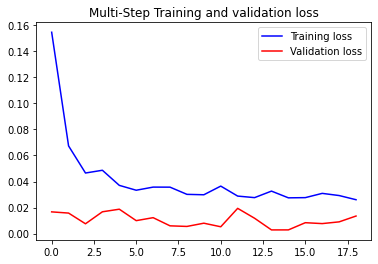

In [436]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",mode='min',patience=5, restore_best_weights=True)

multi_step_history_2 = multi_step_model_2.fit(train_data_multi_2, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi_2,
                                          validation_steps=50,
                                          callbacks=[earlyStop])
plot_train_history(multi_step_history_2, 'Multi-Step Training and validation loss')

In [437]:
multi_step_model_2.evaluate(x_train_multi_2,y_train_multi_2, verbose=0)

0.014038106480075295

In [438]:
multi_step_model_2.evaluate(x_val_multi_2,y_val_multi_2, verbose=0)

0.0036036908518372462

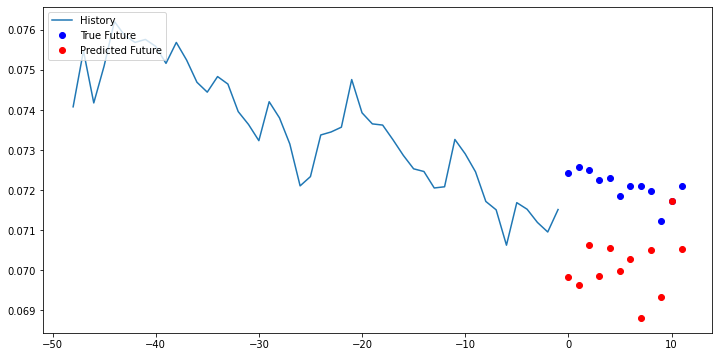

In [439]:
for x, y in val_data_multi_2.take(1):
    multi_step_plot(x[0], y[0], multi_step_model_2.predict(x)[0])